# Prepare street names for classification
In diesem Notebook werden die Daten des [Amtliches Verzeichnis der Strassen](https://www.cadastre.ch/de/services/service/registry/street.html) für das Matching mit weiteren Datenquellen aufbereitet.

## Load Dataset
Load dataset "official list of streets" of Switzerland

In [1]:
#Load all needed libraries
import urllib.request
from zipfile import ZipFile
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Javascript
import numpy as np

In [3]:
url = 'https://data.geo.admin.ch/ch.swisstopo.amtliches-strassenverzeichnis/csv/2056/ch.swisstopo.amtliches-strassenverzeichnis.zip'
filehandle, _ = urllib.request.urlretrieve(url)

with ZipFile(filehandle, 'r') as zip:
    #zip.printdir()
    data = zip.read("pure_str.csv")
    
daten = StringIO(str(data,'UTF-8-SIG'))

streetnames = pd.read_csv(daten, encoding='UTF-8-SIG', sep=';')
streetnames.head()  


,STR_ESID,STN_LABEL,ZIP_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_TYPE,STR_STATUS,STR_OFFICIAL,STR_VALID,STR_MODIFIED,STR_EASTING,STR_NORTHING
0,10258316,Eggwald,6484 Wassen UR,1220,Wassen,UR,Place,real,True,False,10.09.2022,NaN,NaN
1,10023770,Wiedenweg,4203 Grellingen,2786,Grellingen,BL,Street,real,True,True,09.09.2022,2610733.0,1254311.0
2,10179192,Wuhrbärgli,4253 Liesberg,2788,Liesberg,BL,Street,real,True,True,26.08.2022,2598709.0,1249640.0
3,10250501,Hüethütte Unter Trübsee,6390 Engelberg,1511,Wolfenschiessen,NW,Area,real,True,True,07.08.2021,2671798.0,1184817.0
4,10163108,Heimstenstich,4436 Liedertswil,2890,Liedertswil,BL,Area,real,True,True,14.10.2022,2621856.0,1248672.0


## Clean Dataset

Keep only streets (remove areas and places)
Total streetnames = 221'253 
Only with STR_TYPE = Street = 171'966 

In [4]:
streetnames = streetnames[streetnames.STR_TYPE == 'Street']

Check for missing data & remove 108 missing values in STR_EASTING & STR_NORTHING

In [5]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

streetnames = streetnames.dropna()

              Missing Values
STR_ESID                   0
STN_LABEL                  0
ZIP_LABEL                  0
COM_FOSNR                  0
COM_NAME                   0
COM_CANTON                 0
STR_TYPE                   0
STR_STATUS                 0
STR_OFFICIAL               0
STR_VALID                  0
STR_MODIFIED               0
STR_EASTING              108
STR_NORTHING             108


    Check data types to streetname dataset

In [6]:
data_types = pd.DataFrame(
    streetnames.dtypes,
    columns=['Data Type'])

print(data_types)

             Data Type
STR_ESID         int64
STN_LABEL       object
ZIP_LABEL       object
COM_FOSNR        int64
COM_NAME        object
COM_CANTON      object
STR_TYPE        object
STR_STATUS      object
STR_OFFICIAL      bool
STR_VALID         bool
STR_MODIFIED    object
STR_EASTING    float64
STR_NORTHING   float64


Check if the values are unique and analyze values in columns

In [7]:
unique_values = pd.DataFrame(
    columns=['Unique Values'])
      
for row in list(streetnames.columns.values):
    unique_values.loc[row] = [streetnames[row].nunique()]
    
print(unique_values)

streetnames.groupby('STR_VALID').size()
   

              Unique Values
STR_ESID             171879
STN_LABEL             96381
ZIP_LABEL              6465
COM_FOSNR              2082
COM_NAME               2082
COM_CANTON               26
STR_TYPE                  1
STR_STATUS                2
STR_OFFICIAL              2
STR_VALID                 2
STR_MODIFIED            164
STR_EASTING          122677
STR_NORTHING         101903


STR_VALID
False      4702
True     167177
dtype: int64

Remove columns that are no longer needed.

Removed information:
STR_VALID == False: 4705 /
STR_STATUS == planned: 183 /
STR_OFFICIAL == False: 537 /
STR_TYPE: all Street /
COM_FOSNR: No analysis per ZIP planned /
STR_MODIFIED: All recently modified (oldest in 2021)

In [8]:
streetnames = streetnames.drop (['STR_TYPE', 'STR_VALID', 'STR_STATUS', 'ZIP_LABEL', 'STR_MODIFIED'], axis=1)

## Remove street terms 

Most common street names

In [9]:
most_common = streetnames.groupby("STN_LABEL").count()
most_common.COM_FOSNR.nlargest(10)

STN_LABEL
Dorfstrasse         637
Bahnhofstrasse      518
Hauptstrasse        484
Birkenweg           321
Kirchweg            313
Schulstrasse        293
Oberdorfstrasse     268
Industriestrasse    259
Schulhausstrasse    244
Rosenweg            243
Name: COM_FOSNR, dtype: int64

Count and visualize steet terms (not case sensitive)
DE: 'wegli', 'strasse', 'weg', 'platz', 'gasse', 'gässli', 'wäg',
FR: 'avenue ', 'ave. ', 'boulevard ', 'chemin ', 'impasse ', 'place', 'route ', 'rue ', 'ruelle ', 
IT: 'piazza ', 'via ', 'viale '

Important: Add spaces to words that are often string within other words (You can test ist with 'rue' vs 'rue '

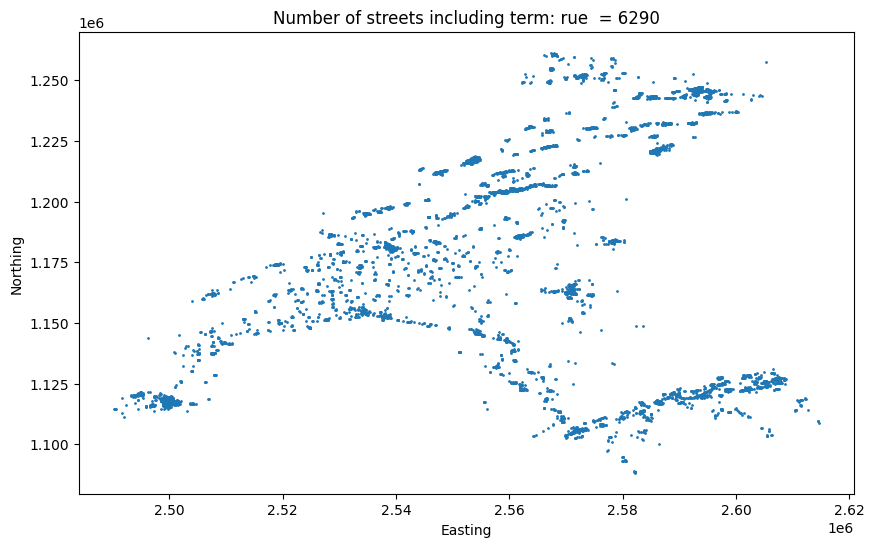

In [10]:
searchString = "rue "
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=False)]
count = len(searchStringStrassen)
count = "Number of streets including term: "+ searchString + " = "+  str(count)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 1)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.show()

Delete spaces at the beginning and end of the string using function 'strip()'

In [11]:
#Create new Column (so we can always compare with original values)
streetnames ['STN_LABEL_NO_BI'] = streetnames.loc[:, 'STN_LABEL']

streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

Delete everything (in string) after bracket and slash. We do this mainly to keep only the first language in bilingual names.

In [12]:
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(/).*","", regex=True)
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(\().*","", regex=True)

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

#Check if it worked
streetnames[streetnames["STN_LABEL_NO_BI"].str.contains("Chandosselweg|Figgione")].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI
757,10022105,Chandosselweg / Chemin de Chandossel,2250,Courgevaux,FR,True,2574274.0,1194118.0,Chandosselweg
220140,10244635,Figgione (nucleo),5072,Faido,TI,True,2706220.0,1148322.0,Figgione


Duplicate column of street names

In [13]:
streetnames ['STN_LABEL_NO_TERMS'] = streetnames.loc[:, 'STN_LABEL_NO_BI']

Move (to new column) and replace street terms

Important: Add spaces to words that are often string within other words (e.g. 'rue' vs 'rue ')
Always substring afterwards: 'wegli' before 'weg' 

In [14]:
terms = ('strasse', 'wegli', 'platz', 'gasse', 'gässli', 'wäg', 'strässli', 'allee', 'graben', "anlage", "steg", "brücke", "schanze", "rain", "stieg", "platz", "ring", 
'avenue ', 'boulevard ', 'chemin ', 'impasse ', 'place ', 'route', 'ruelle ', 'rue ', 
'sentier ', 'passage ', 'promenade', 'quai',
'piazza ', 'viale ', 
'strada ', 'veia ', 'vietta ', 'gassa ', 'voia ','voa')

terms2 = ('weg', 'via ')
    
for i in terms2:
    streetnames.loc[streetnames.STN_LABEL.str.contains(i,case=False), 'STR_TERMS'] = i
        
for i in terms:
    streetnames.loc[streetnames.STN_LABEL.str.contains(i,case=False), 'STR_TERMS'] = i
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)

for i in terms2:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_TERMS'] = streetnames['STR_TERMS'].str.strip()

In [15]:
streetnames.groupby('STR_TERMS',dropna=False).size()

STR_TERMS
allee          124
anlage          22
avenue         707
boulevard       31
brücke         158
chemin       15019
gassa           47
gasse         3734
graben         570
gässli         994
impasse       1147
passage        273
piazza          42
place          168
platz          617
promenade      248
quai           166
rain          2498
ring           709
route         6822
rue           6275
ruelle         703
schanze         23
sentier        390
steg           288
stieg          173
strada         321
strasse      48055
strässli        15
veia           157
via           6769
viale           51
vietta          26
voa             59
voia            49
weg          42093
wegli          221
wäg            233
NaN          31882
dtype: int64

In [16]:
streetnames.head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse


## Remove prepositions, stopwords and special characters

First replace special caracters and punctuation marks

In [17]:
special = (['.', ' '],[',', ' '],[';', ' '],[':', ' '],['-', ' '],['\'', ' '],[',', ' '],[' ', ' '],
['è', 'e'],['é', 'e'],['ê', 'e'],['ë', 'e'],['à', 'a'],['á', 'a'],['â', 'a'],['ô', 'o'],['ò', 'o'],['ó', 'o'],
['û', 'u'],['ù', 'u'],['ú', 'u'],['ï', 'i'],['í', 'i'],['î', 'i'],['ç', 'c'])
# Not useful for matching with wikidata,['ä', 'ae'],['ü', 'ue'],['ö', 'oe']        )

for i in special:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],i[1],case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()

Then move (to new column) and replace designations

For the cases with more than one designation we only keep the last designation in the dictionary.

In [18]:
terms = (['hinterer ', 'hinter'],['hinteren ', 'hinter'],['hinteres ', 'hinter'],['hintere ', 'hinter'],['hinter ', 'hinter'],
['oberen ', 'ober'],['oberer ', 'ober'],['oberes ', 'ober'],['obere ', 'ober'],['ober ', 'ober'],['oberi ', 'ober'],
['vorderen ', 'vorder'],['vorderer ', 'vorder'],['vorderes ', 'vorder'],['vordere ', 'vorder'],['vorder ', 'vorder'],
['unteren ', 'unter'],['unterer ', 'unter'],['unteres ', 'unter'],['untere ', 'unter'],['unter ', 'unter'],['sous ', 'unter'],['unterem ', 'unter'],['unterm ', 'unter'],
['mittleren ', 'mittler'],['mittlerer ', 'mittler'],['mittleres ', 'mittler'],['mittlere ', 'mittler'],['mittler ', 'mittler'],
['äusseren ', 'äusser'],['äusserer ', 'äusser'],['äusseres ', 'äusser'],['äussere ', 'äusser'],['äusser ', 'äusser'],
['inneren ', 'inner'],['innerer ', 'inner'],['inneres ', 'inner'],['innere ', 'inner'],['inner ', 'inner'],
['kleines ', 'klein'],['kleiner ', 'klein'],['kleinen ', 'klein'],['kleine ', 'klein'],['klein ', 'klein'],['petite ', 'klein'],['petit ', 'klein'],
['grosses ', 'gross'],['grosser ', 'gross'],['grossen ', 'gross'],['grosse ', 'gross'],['gross ', 'gross'],['grand ', 'gross'],['grande ', 'gross'],
['san ', 'sankt'],['santa ', 'sankt'],['sankt ', 'sankt'],['saint ', 'sankt'],['sainte ', 'sankt'],['st ', 'sankt'],['ste ', 'sankt'],
['ancien ', 'alt'],['ancienne ', 'alt'],['alte ', 'alt'],['alter ', 'alt'],['altes ', 'alt'],['alten ', 'alt'],
['mont ', 'mont'])

for i in terms:
    streetnames.loc[streetnames.STN_LABEL_NO_TERMS.str.contains(i[0],case=False), 'STR_PREPS'] = i[1]
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],'',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_PREPS'] = streetnames['STR_PREPS'].str.strip()

In [19]:
streetnames[streetnames["STN_LABEL"].str.contains('Wolfgalgenstutz')].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS
33,10142028,Wolfgalgenstutz,2851,Kilchberg (BL),BL,True,2634691.0,1252654.0,Wolfgalgenstutz,Wolfgalgenstutz,NaN,NaN


In [20]:
streetnames.groupby('STR_PREPS',dropna=False).size()

STR_PREPS
alt          1106
gross         450
hinter        328
inner          58
klein         265
mittler       163
mont          115
ober         1519
sankt        1024
unter        1541
vorder        191
äusser         57
NaN        165062
dtype: int64

Finally create final column (for matching with other datasets) and remove stopwords

In [21]:
streetnames ['STN_LABEL_FINAL'] = streetnames.loc[:, 'STN_LABEL_NO_TERMS']

In [22]:
stop = ('le' ,'la' , 'en' , 'au' , 'da' ,'im' , 'in' , 'ai' , 'al' ,
        'am' , 'l''','a'  ,'les', 'auf', 'aux', 'bei','der', 'die', 
        'das','zum', 'beim', 'de', 'des', 'du', 'd''', 'della', 'alla', 
        'di', 'delle', 'del', 'dei', 'den', 'dal', 'zur', 'vers',
        'Le' ,'La' , 'En' , 'Au' , 'Da' ,'Im' , 'In' , 'Ai' , 'Al' ,
        'Am' , 'L''','A'  ,'Les', 'Auf', 'Aux', 'Bei','Der', 'Die', 
        'Das','Zum', 'Beim', 'De', 'Des', 'Du', 'D''', 'Della', 'Alla', 
        'Di', 'Delle', 'Del', 'Dei', 'Den', 'Dal', 'Zur', 'Zers', 'sur', 'Sur')

#streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.lower().str.split(' ')
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.split(' ')

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].apply(lambda x: [item for item in x if item not in stop])

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.join(' ')

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.strip()

In [23]:
streetnames

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg,NaN,Wieden
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN,NaN,Wuhrbärgli
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg,NaN,Emanuelen
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg,NaN,Löhr
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse,NaN,Brunn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
221280,10107114,Tannenstrasse,4471,Bischofszell,TG,True,2736565.0,1261881.0,Tannenstrasse,Tannen,strasse,NaN,Tannen
221281,10070806,Rebenstrasse,4724,Eschlikon,TG,True,2716120.0,1258548.0,Rebenstrasse,Reben,strasse,NaN,Reben
221283,10142291,Fritz-Gegauf-Strasse,4864,Steckborn,TG,True,2715726.0,1280124.0,Fritz-Gegauf-Strasse,Fritz Gegauf,strasse,NaN,Fritz Gegauf
221285,10093237,Obere Bleichewiese,4571,Gachnang,TG,True,2705606.0,1266777.0,Obere Bleichewiese,Bleichewiese,NaN,ober,Bleichewiese


## Useful for optimization of designations and stop words

In [24]:
most_common = streetnames.groupby("STN_LABEL_FINAL").count()
pd.set_option('display.max_rows', 200)
most_common.COM_FOSNR.nlargest(200)

STN_LABEL_FINAL
                  1182
Dorf               908
Kirch              819
Bahnhof            709
Schul              589
Haupt              518
Halden             488
Oberdorf           483
Bach               427
Mühle              421
Garten             411
Birken             409
Linden             398
Feld               376
Berg               374
Moos               367
Schulhaus          364
Post               355
Industrie          343
Rosen              341
Sonnen             322
Weid               319
Rüti               309
Unterdorf          309
Matten             305
Winkel             289
Höhen              287
Wiesen             274
Erlen              271
Baumgarten         270
Blumen             264
Jura               256
Allmend            246
Buchen             236
Ahorn              230
See                223
Gare               220
Schützen           218
Eglise             210
Hof                208
Friedhof           203
Schloss            201
Grund             

In [25]:
#Example: filter all special street designations with ' ' (more than one word)

test = streetnames.STN_LABEL_FINAL.dropna()

filter2 = test.loc[test.str.match('Käser', case=False)]

with pd.option_context("display.max_rows", 20000):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

766                   Käserei
1896                  Käserei
30634                 Käserei
34714                 Käserei
44869                 Käserei
55612                 Käserei
57008                 Käserei
59342                 Käserei
60437               Käserfeld
61540                 Käserei
62072                 Käserei
62554                 Käserei
62634                 Käserei
64046                 Käserei
64145                 Käserei
64605                 Käserei
64775                 Käserei
65266                 Käserei
65379                 Käserei
67750                 Käserei
68025                 Käserei
68479                 Käserei
69072                 Käserei
69535                 Käserei
70563                 Käserei
71249                 Käserei
71780                 Käserei
73300                 Käserei
75092                 Käserei
75341                 Käserei
75367                 Käserei
75734                 Käserei
77454                 Käserei
78029     

Number of streets including term: 140


In [ ]:
#Example2: filter all special street designations with 'Rue' but not 'Rue.'

filter2 = streetnames.loc[(streetnames.STN_LABEL_FINAL.str.contains("kirch")) & 
                          (~streetnames.STN_LABEL_FINAL.str.contains("kirch.", regex=True))]

with pd.option_context("display.max_rows", 20000):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

In [ ]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

Command to run all cells above

In [ ]:
#from IPython.display import Javascript
#display(Javascript('IPython.notebook.execute_cells_above()'))

In [ ]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

In [ ]:
streetnames.to_csv('streetnames.csv', encoding='UTF-8-SIG', sep=';')